<a href="https://colab.research.google.com/github/NikosMav/fake-news-classification/blob/main/fake_news_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Τεχνικές Εξόρυξης Δεδομένων (ΥΣ11)**

**2η Προγραμματιστική Άσκηση**

> **Φοιτητές**: Αναστάσιος Μελιδώνης(sdi1700084), Νικόλαος Μαυραπίδης(sdi1700082)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries and Preparing the Data

Import the packages needed.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px
import warnings

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Read the files.

In [ ]:
df_true = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Τεδε/Ergasia2/True.csv")
df_fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Τεδε/Ergasia2/Fake.csv")

Setting up a label (validity) variable and combining both the real and fake news datasets.

In [ ]:
# Create 5th column
df_true['label'] = 1
df_fake['label'] = 0

# Concat dfs into one
df_all = pd.concat([df_true, df_fake]).reset_index(drop = True)
df_all.head()

title  ... label
0  As U.S. budget fight looms, Republicans flip t...  ...     1
1  U.S. military to accept transgender recruits o...  ...     1
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...     1
3  FBI Russia probe helped by Australian diplomat...  ...     1
4  Trump wants Postal Service to charge 'much mor...  ...     1

[5 rows x 5 columns]

Create another column storing the title and the text of the news.

In [ ]:
# Create 6th column
df_all['original'] = df_all['title'] + ' / ' + df_all['text']
df_all.head()

title  ...                                           original
0  As U.S. budget fight looms, Republicans flip t...  ...  As U.S. budget fight looms, Republicans flip t...
1  U.S. military to accept transgender recruits o...  ...  U.S. military to accept transgender recruits o...
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  Senior U.S. Republican senator: 'Let Mr. Muell...
3  FBI Russia probe helped by Australian diplomat...  ...  FBI Russia probe helped by Australian diplomat...
4  Trump wants Postal Service to charge 'much mor...  ...  Trump wants Postal Service to charge 'much mor...

[5 rows x 6 columns]

Lets take a note of the null values in the data.

In [ ]:
df_all.isnull().sum()

title       0
text        0
subject     0
date        0
label       0
original    0
dtype: int64

We can see that our dataframe has no missing data. So we are good to go...

# Preprocessing and Cleaning

In [ ]:
stop_words = stopwords.words('english')
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

In [ ]:
# Function to convert  
def listToString(s): 
    # initialize an empty string
    str1 = " "
    # return string  
    return (str1.join(s))

In [ ]:
# Apply cleaning function to title and text
df_all['processed_title'] = df_all['title'].apply(preprocess)
df_all['processed_text'] = df_all['text'].apply(preprocess)

# then from list back to string
df_all['processed_title'] = df_all['processed_title'].apply(listToString)
df_all['processed_text'] = df_all['processed_text'].apply(listToString)
df_all.head()

title  ...                                     processed_text
0  As U.S. budget fight looms, Republicans flip t...  ...  washington reuters head conservative republica...
1  U.S. military to accept transgender recruits o...  ...  washington reuters transgender people allowed ...
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  washington reuters special counsel investigati...
3  FBI Russia probe helped by Australian diplomat...  ...  washington reuters trump campaign adviser geor...
4  Trump wants Postal Service to charge 'much mor...  ...  seattle washington reuters president donald tr...

[5 rows x 8 columns]

# Data Analysis

Let's take a look at our dataframes...

## News Subjects

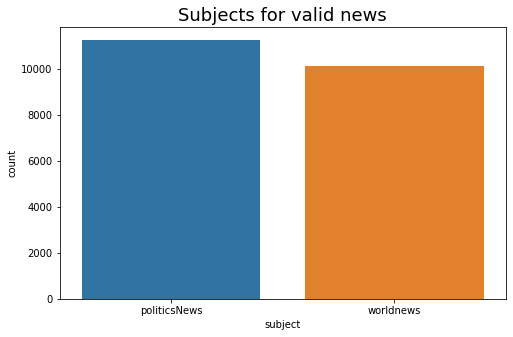

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='subject', data=df_true, order=df_true.subject.value_counts().index[:,])
plt.title('Subjects for valid news', size=18);

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='subject', data=df_fake, order=df_fake.subject.value_counts().index[:,])
plt.title('Subjects for fake news', size=18);

In [ ]:
# plt.figure(figsize=(12,8))
# sns.countplot(x='subject', data=df_all, order=df_all.subject.value_counts().index[:,])
# plt.title('Subjects for all news', size=18);

## Word Clouds for News Titles

Create a Word Cloud using the **Valid News Titles** in order to see the **most common** key words valid news titles use.

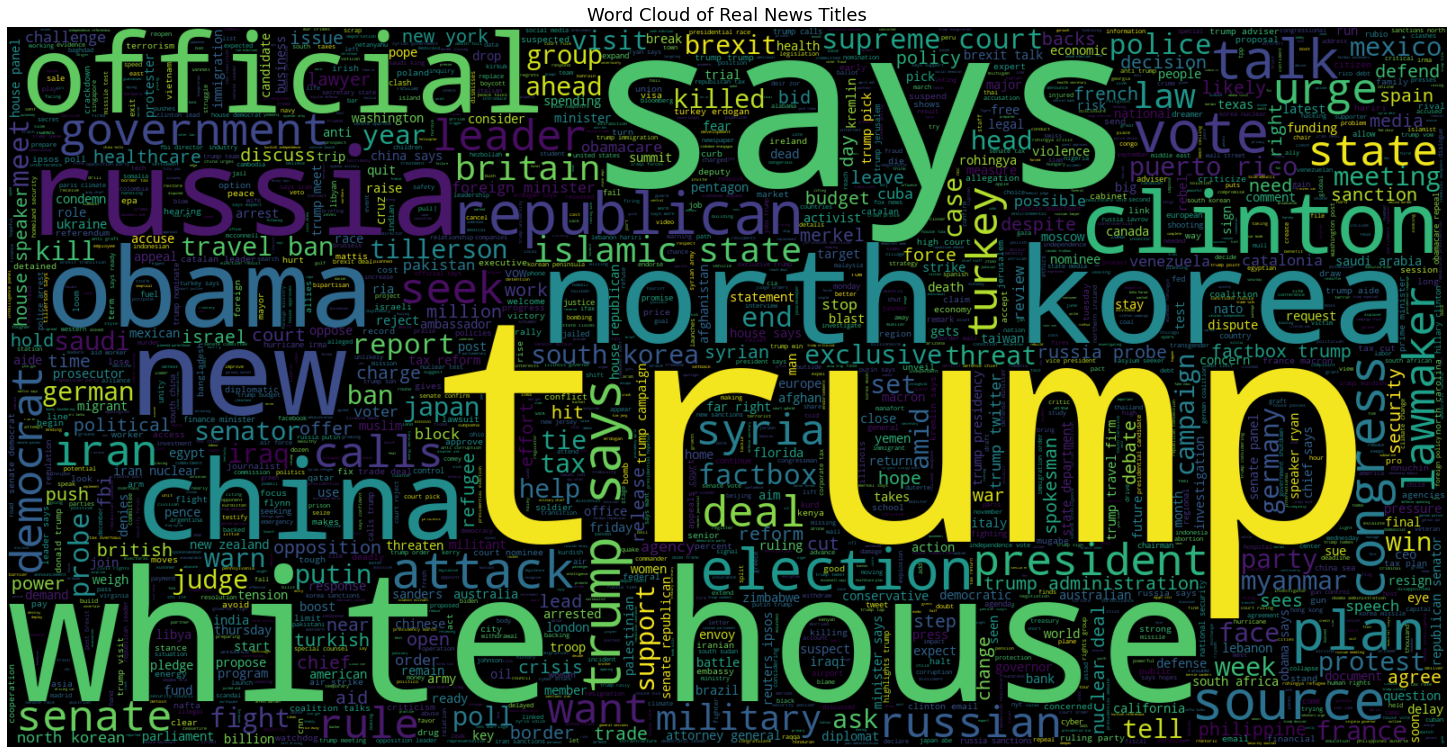

In [ ]:
# α. Οπτικοποιήστε τους τίτλους των fake και των non-fake news έτσι ώστε να μπορεί
# κάποιος να εντοπίσει τα κεντρικά θέματα τα οποία διαπραγματεύονται τα άρθρα.

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_all[df_all.label == 1].processed_title))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud of Real News Titles', size=18);

Same with the **Fake News Titles**.

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_all[df_all.label == 0].processed_title))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud of Fake News Titles', size=18);

**Observation**: As we can see Fake and Valid News **share some frequently used words** such as "trump", "obama", "clinton", "says" etc. Therefore we can not **decide** with **absolute certainty** whether a news article is fake or not. However as we can see, there are some words which **can describe and characterize** the content of the certain news article and it's credibility. 

## Average Number of Characters in Titles and Texts

Plot the **average number of characters** in valid and fake news **titles**...

In [ ]:
# β. Σχεδιάστε γραφήματα που να δείχνουν το μέσο όρο των χαρακτήρων στα fake και
# στα true news αντίστοιχα. Κάντε το ίδιο και για τη στήλη text.

fig = px.histogram(x = [(len(x) - x.count(' ')) for x in df_all[df_all.label == 1].title])
fig.update_layout(title="Average Number of Characters in Valid News Titles")
fig.show()

In [ ]:
fig = px.histogram(x = [(len(x) - x.count(' ')) for x in df_all[df_all.label == 0].title])
fig.update_layout(title="Average Number of Characters in Fake News Titles")
fig.show()

**Observation**: On average, the maximum number of **characters in titles** of **valid** **news** range between $52-58$ characters whereas the maximum number of **characters in titles** of **fake** **news** range between $70-79$ characters. Would be a bit tricky to judge if the news are true or fake **only by the number of characters** in their **titles**. So lets continue until we find a better distinguishing factor.

Lets do the **same** with the **news text** and check whether we can find a usefull pattern...

In [ ]:
fig = px.histogram(x = [(len(x) - x.count(' ')) for x in df_all[df_all.label == 1].text])
fig.update_layout(title="Average Number of Characters in Valid News Text")
fig.show()

In [ ]:
fig = px.histogram(x = [(len(x) - x.count(' ')) for x in df_all[df_all.label == 0].text])
fig.update_layout(title="Average Number of Characters in Fake News Text")
fig.show()

**Observation**: On average again, the maximum number of **characters in texts** of **valid** **news** range between $300-500$ characters whereas the maximum number of **characters in texts** of **fake** **news** range between $1500-1900$ characters. There is a **clear difference** here regarding the length of the words of the news articles. We **also** observe that **some fake news** articles have a little to none characters, which is an interesting pattern.

## Average Number of Words in Titles and Text

Plot the **average number of words** in valid and fake news **titles**...

In [ ]:
# γ. Σχεδιάστε την κατανομή του αριθμού των λέξεων για τη στήλη title και για 
# τη στήλη text

fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 1].title])
fig.update_layout(title="Average Number of Words in Valid News Titles")
fig.show()

In [ ]:
fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 0].title])
fig.update_layout(title="Average Number of Words in Fake News Titles")
fig.show()

**Observation**: On average, the maximum number **of words in titles** of **valid** **news** range between $9-11$ words whereas the maximum number **of words in titles** of **fake** **news** range between $13-16$ words. Would be a bit tricky to judge if the news are true or fake **only by the number of words** in their **titles**.

Some titles of **fake news** may have more words making the title **provocative** or **attractive** for the person to read. This is a common practice for fake news publishers but we still can not be sure just by the article's title length. 

Lets do the **same** with the **news text** and check whether we can find a usefull pattern...

In [ ]:
fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 1].text])
fig.update_layout(title="Average Number of Words in Valid News Text")
fig.show()

In [ ]:
fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 0].text])
fig.update_layout(title="Average Number of Words in Fake News Text")
fig.show()

**Observation**: On average again, the maximum **number of words in texts** of **valid** **news** range between $60-100$ and $400-420$ words whereas the maximum **number of words in texts** of fake news range between $0-20$ and $310-370$ words. There is a **clear difference** here regarding the length of the news articles.

**Observation**: As we can see **fake** **news** tend to keep their articles a bit **short** **in size** including **few and large words**, whereas **valid** **news** have **more** **words** in their text, which seem to be more **common** and **simple** for the user to read, informing him and providing valid information with sources and examples. 

This goes to show that fake news tend to elongate their articles with **incomprehensible** **long** **words**, **obsuring and distorting** the content of the article and **misinforming** the reader. On the other hand, non-fake news keep their articles **simple** and **easy to read**, while also providing more **information**, **examples**, **reliable sources** etc.

## Average Number of Modyfied Words in Titles and Text

Lets observe the above graphs after **removing the stop-words and processing** the titles and texts...

In [ ]:
# δ. Επαναλλάβετε το προηγούμενο ερώτημα αφαιρώντας τα stopwords.

fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 1].processed_title])
fig.update_layout(title="Average Number of Words in Valid News Titles after modyfing them")
fig.show()

In [ ]:
fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 0].processed_title])
fig.update_layout(title="Average Number of Words in Fake News Titles after modyfing them")
fig.show()

In [ ]:
fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 1].processed_text])
fig.update_layout(title="Average Number of Words in Valid News Text after modyfing them")
fig.show()

In [ ]:
fig = px.histogram(x = [len(x.split(" ")) for x in df_all[df_all.label == 0].processed_text])
fig.update_layout(title="Average Number of Words in Fake News Text after modyfing them")
fig.show()

**Observation**: The patterns **are the same** even after removing stop-words and modyfing the titles and text.

## Common Bigrams in Titles and Text

Lets see the **most common continuous sequence of 2 items** from the given **title** and **text** (valid and fake news).

In [ ]:
# ε. Ποιά είναι τα πιο συχνά (πχ 10 ή 20) bigrams στους τίτλους και ποιά στο κυρίως
# άρθρο;

# Get the valid news title words
true_title_words = [x.split(' ') for x in df_all[df_all.label == 1].processed_title]
# Flatten the list
true_title_words = [item for sublist in true_title_words for item in sublist]

# Get the bigrams
bigram_all = (pd.Series(ngrams(true_title_words, 2)).value_counts())[:10]
bigram_all=pd.DataFrame(bigram_all)

print("Top 10 most common bigrams in Valid News Titles: ")
bigram_all

Top 10 most common bigrams in Valid News Titles: 


0
(white, house)           790
(north, korea)           720
(trump, says)            364
(islamic, state)         251
(supreme, court)         235
(puerto, rico)           178
(south, korea)           160
(says, trump)            159
(travel, ban)            156
(trump, administration)  148

In [ ]:
# Get the fake news title words
fake_title_words = [x.split(' ') for x in df_all[df_all.label == 0].processed_title]
# Flatten the list
fake_title_words = [item for sublist in fake_title_words for item in sublist]

# Get the bigrams
bigram_all = (pd.Series(ngrams(fake_title_words, 2)).value_counts())[:10]
bigram_all=pd.DataFrame(bigram_all)

print("Top 10 most common bigrams in Fake News Titles: ")
bigram_all

Top 10 most common bigrams in Fake News Titles: 


0
(donald, trump)     805
(video, watch)      509
(president, trump)  504
(video, trump)      460
(hillary, clinton)  417
(white, house)      348
(fox, news)         314
(trump, video)      311
(video, breaking)   270
(anti, trump)       261

In [ ]:
# Get the valid news text words
true_text_words = [x.split(' ') for x in df_all[df_all.label == 1].processed_text]
# Flatten the list
true_text_words = [item for sublist in true_text_words for item in sublist]

# Get the bigrams
bigram_all = (pd.Series(ngrams(true_text_words, 2)).value_counts())[:10]
bigram_all=pd.DataFrame(bigram_all)

print("Top 10 most common bigrams in Valid News Text: ")
bigram_all

Top 10 most common bigrams in Valid News Text: 


0
(united, states)       12204
(donald, trump)        10168
(white, house)          8419
(washington, reuters)   6679
(president, donald)     5930
(north, korea)          5659
(new, york)             4740
(prime, minister)       4163
(said, statement)       3934
(trump, said)           3586

In [ ]:
# Get the fake news text words
fake_text_words = [x.split(' ') for x in df_all[df_all.label == 0].processed_text]
# Flatten the list
fake_text_words = [item for sublist in fake_text_words for item in sublist]

# Get the bigrams
bigram_all = (pd.Series(ngrams(fake_text_words, 2)).value_counts())[:10]
bigram_all=pd.DataFrame(bigram_all)

print("Top 10 most common bigrams in Fake News Text: ")
bigram_all

Top 10 most common bigrams in Fake News Text: 


0
(donald, trump)     16395
(featured, image)    8063
(hillary, clinton)   7307
(white, house)       6745
(united, states)     6663
(twitter, com)       6567
(pic, twitter)       6232
(new, york)          4359
(president, obama)   4095
(president, trump)   4049

# Model Training and Classification

## Create Train and Test Datasets

In [ ]:
# creating new csv files
# getting a percentage (fraction) of all the news using frac argument with random choices, use frac=1 for whole dataset
sampled = df_all.sample(frac=1, random_state=7,replace=True)

# split train and test dataframes
position = int(sampled.shape[0] * 0.8)
train = sampled.iloc[:position]
test = sampled.iloc[position:]

# removing unwanted columns
test = test.drop(columns=['original', 'text', 'title'])
train = train.drop(columns=['original', 'text', 'title'])
# renaming columns
test = test.rename(columns={'processed_title': 'title', 'processed_text': 'text'})
train = train.rename(columns={'processed_title': 'title', 'processed_text': 'text'})

# saving...
test.to_csv(r"test.csv")
train.to_csv(r"train.csv")

!cp test.csv "/content/drive/MyDrive/Colab Notebooks/Τεδε/Ergasia2/"
!cp train.csv "/content/drive/MyDrive/Colab Notebooks/Τεδε/Ergasia2/"

We have created the train and test datasets. Let's see now their analogies and their sizes...

In [ ]:
# printing the sizes of the dataframes
print("Number of news in TEST dataset is -> ", test.shape[0])
print("Number of news in TRAIN dataset is -> ", train.shape[0], "\n")

print("The number of the FAKE news in the TRAIN dataset is -> " + str(train[train.label == 0].shape[0]))
print("The number of the TRUE news in the TRAIN dataset is -> " + str(train[train.label == 1].shape[0]))
print("Analogy of real-fake news is -> " + str(round((train[train.label == 0].shape[0]/train.shape[0])*100,2)) + "% - " + str(round((train[train.label == 1].shape[0]/train.shape[0])*100,2)) +"%")
print("")
print("The number of the FAKE news in the TEST dataset is -> " + str(test[test.label == 0].shape[0]))
print("The number of the TRUE news in the TEST dataset is -> " + str(test[test.label == 1].shape[0]))
print("Analogy of real-fake news is -> " + str(round((test[test.label == 0].shape[0]/test.shape[0])*100,2)) + "% - " + str(round((test[test.label == 1].shape[0]/test.shape[0])*100,2)) +"%")


Number of news in TEST dataset is ->  8980
Number of news in TRAIN dataset is ->  35918 

The number of the FAKE news in the TRAIN dataset is -> 18797
The number of the TRUE news in the TRAIN dataset is -> 17121
Analogy of real-fake news is -> 52.33% - 47.67%

The number of the FAKE news in the TEST dataset is -> 4624
The number of the TRUE news in the TEST dataset is -> 4356
Analogy of real-fake news is -> 51.49% - 48.51%


## News Classification

In all of our classifications we train and test our models juts by the title of the news.

### Needed Funtions

In [ ]:
def document_vector(doc, w2v):
  # Create document vectors by averaging word vectors
  doc = doc.split(' ')
  doc = [word for word in doc if word in w2v.wv.vocab]

  return np.mean(w2v[doc], axis=0)

In [ ]:
def ignore_warnings():
  # ignore the deprecassion warning
  warnings.filterwarnings("ignore")

In [ ]:
def enable_warnings():
  warnings.simplefilter('always')

### Compute Vectorizers(count - tfidf - word2vec)

In [ ]:
ignore_warnings()

# COUNT VECTORIZER
CountVec = CountVectorizer(
                        ngram_range=(1,2), # (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
                        lowercase=True
                        )
# Initializing some parameters one time to be used by BOW implementation models
vec_train = CountVec.fit(train.text)
X_vec_train = vec_train.transform(train.text)
X_vec_test = vec_train.transform(test.text)

# TF-IDF VECTORIZER
tf_idf_vec = TfidfVectorizer(
                      use_idf=True,
                      ngram_range=(1,2), # (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
                      smooth_idf=True, # Prevents divide-by-zero errors
                      lowercase=True # Convert everything to lower case 
                      )
# Initializing some parameters one time to be used by TF-IDF implementation models
vec_train_tf = tf_idf_vec.fit(train.text)
X_vec_train_tf = vec_train_tf.transform(train.text)
X_vec_test_tf = vec_train_tf.transform(test.text)

# Word2Vec VECTORIZER

# creating a list of words from the titles
X = [x.split(' ') for x in train.text]

EMBEDDING_DIM = 100
# creating the w2v model
w2v = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)
# creating temp dataframes
trainTemp = train
testTemp = test

# Initializing some parameters one time to be used by word2vec implementation models

# applying the function and creating a new column
trainTemp['doc_vector'] = trainTemp.text.apply(document_vector, args=(w2v,))
testTemp['doc_vector'] = testTemp.text.apply(document_vector, args=(w2v,))

X_train = list(trainTemp['doc_vector'])
X_test = list(testTemp['doc_vector'])

y_train = train.label
y_test = test.label

### Logistic Regression

In [ ]:
def LogisticRegressionCountImplementation(train, test):
  model = LogisticRegression(C=2.5)
  
  model.fit(X_vec_train, train.label)
  
  predicted_value = model.predict(X_vec_test)
  
  accuracy_value = roc_auc_score(test.label, predicted_value)
  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,predicted_value)))

In [ ]:
def LogisticRegressionTfidfImplementation(train, test):
  model = LogisticRegression(C=2.5)
  
  model.fit(X_vec_train_tf, train.label)
  
  predicted_value = model.predict(X_vec_test_tf)
  
  accuracy_value = roc_auc_score(test.label, predicted_value)
  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,predicted_value)))

In [ ]:
def LogisticRegressionWord2VecImplementation(train, test):
  model = LogisticRegression(C=100)
  
  model.fit(X_train, train.label)

  predicted_value = model.predict(X_test)
  
  accuracy_value = roc_auc_score(test.label, predicted_value)
  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,predicted_value)))

In [ ]:
print("Logistic Regression with BOW, Tf-Idf and Word2Vec accordingly")
ignore_warnings()
LogisticRegressionCountImplementation(train, test)
LogisticRegressionTfidfImplementation(train,test)
LogisticRegressionWord2VecImplementation(train,test)
enable_warnings()

Logistic Regression with BOW, Tf-Idf and Word2Vec accordingly
Accuracy -> 99.81%
f1 score -> 0.9980488924595432
Accuracy -> 99.11%
f1 score -> 0.9907354454992566
Accuracy -> 96.7%
f1 score -> 0.9660765276984581


### Naive Bayes

In [ ]:
def NaiveBayesCountImplementation(train, test):
  model = MultinomialNB(alpha=0.1)
  
  model.fit(X_vec_train, train.label)
  
  predicted_value = model.predict(X_vec_test)
  
  accuracy_value = roc_auc_score(test.label, predicted_value)
  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,predicted_value)))

In [ ]:
def NaiveBayesTfidfImplementation(train, test):
  model = MultinomialNB(alpha=0.1)
  
  model.fit(X_vec_train_tf, train.label)
  
  predicted_value = model.predict(X_vec_test_tf)
  
  accuracy_value = roc_auc_score(test.label, predicted_value)
  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,predicted_value)))

In [ ]:
def NaiveBayesWord2VecImplementation(train, test):

  model = MultinomialNB(alpha=0.1)

  # normalize values in X_train and X_test for the MultinomialNB
  # first we concatenate the two arrays into one...
  X_temp = np.concatenate((X_train, X_test))

  scaler = MinMaxScaler()
  # fit the scaler with the big array so that it finds the best minimum and maximum...
  scaler.fit(X_temp)
  # then transform the data
  X_temp = scaler.transform(X_temp)

  # then split the array again
  position = len(X_train)
  normalized_X_train, normalized_X_test = X_temp[:position, ...], X_temp[position:, ...]

  model.fit(normalized_X_train, train.label)

  predicted_value = model.predict(normalized_X_test)
  accuracy_value = roc_auc_score(test.label, predicted_value)
  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,predicted_value)))

In [ ]:
print("Naive Bayes with BOW, Tf-Idf and Word2Vec accordingly")
ignore_warnings()
NaiveBayesCountImplementation(train, test)
NaiveBayesTfidfImplementation(train, test)
NaiveBayesWord2VecImplementation(train,test)
enable_warnings()

Naive Bayes with BOW, Tf-Idf and Word2Vec accordingly
Accuracy -> 98.69%
f1 score -> 0.9864957656214236
Accuracy -> 98.27%
f1 score -> 0.9821632746398353
Accuracy -> 87.79%
f1 score -> 0.8679476196304001


### SVM

In [ ]:
def SVMCountImplementation(train, test):
  # SVM classifier
  classifier = SVC(kernel = 'linear', random_state = 0)
  classifier.fit(X_vec_train, y_train)

  # Predicting the Test set results
  y_pred = classifier.predict(X_vec_test)

  accuracy_value = roc_auc_score(test.label, y_pred)

  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,y_pred)))

In [ ]:
def SVMTfidfImplementation(train, test):
  # SVM Classifier
  classifier = SVC(kernel = 'linear', random_state = 0)
  classifier.fit(X_vec_train_tf, y_train)

  # Predicting the Test set results
  y_pred = classifier.predict(X_vec_test_tf)

  accuracy_value = roc_auc_score(test.label, y_pred)

  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,y_pred)))

In [ ]:
def SVMWord2VecImplementation(train, test):
  # SVM classifier 
  classifier = SVC(kernel = 'linear', random_state = 0)
  classifier.fit(X_train, train.label)

  # Predicting the Test set results
  y_pred = classifier.predict(X_test)

  accuracy_value = roc_auc_score(test.label, y_pred)

  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,y_pred)))

In [ ]:
print("SVM with BOW, Tf-Idf and Word2Vec accordingly")
ignore_warnings()
SVMCountImplementation(train,test)
SVMTfidfImplementation(train,test)
SVMWord2VecImplementation(train,test)
enable_warnings()

SVM with BOW, Tf-Idf and Word2Vec accordingly
Accuracy -> 99.81%
f1 score -> 0.9980493402180148
Accuracy -> 99.52%
f1 score -> 0.9949656750572082
Accuracy -> 96.64%
f1 score -> 0.9654622136099396


### Random Forest

In [ ]:
def RandForestBowImplementation(train, test):
  # Random Forest classifier
  classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)  
  classifier.fit(X_vec_train, y_train)
  # Predicting the Test set results
  y_pred = classifier.predict(X_vec_test)

  accuracy_value = roc_auc_score(test.label, y_pred)

  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,y_pred)))

In [ ]:
def RandForestTfidfImplementation(train, test):
  # Random Forest classifier
  classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)  
  classifier.fit(X_vec_train_tf, y_train)
  # Predicting the Test set results
  y_pred = classifier.predict(X_vec_test)

  accuracy_value = roc_auc_score(test.label, y_pred)

  rf_acc_old = round(accuracy_value*100,2)

  print("Accuracy -> " + str(rf_acc_old) + "%")
  print("f1 score -> " + str(f1_score(test.label,y_pred)))

  return rf_acc_old

In [ ]:
def RandForestWord2VecImplementation(train, test):
  # Random forests classifier
  classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
  classifier.fit(X_train, train.label)

  # Predicting the Test set results
  y_pred = classifier.predict(X_test)

  accuracy_value = roc_auc_score(test.label, y_pred)

  print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
  print("f1 score -> " + str(f1_score(test.label,y_pred)))

In [ ]:
print("Random Forest with BOW, Tf-Idf and Word2Vec accordingly")
ignore_warnings()
RandForestBowImplementation(train,test)
# get the old accuracy...
rf_acc_old = RandForestTfidfImplementation(train,test)
RandForestWord2VecImplementation(train,test)
enable_warnings()

Random Forest with BOW, Tf-Idf and Word2Vec accordingly
Accuracy -> 97.43%
f1 score -> 0.9735267034990791
Accuracy -> 95.6%
f1 score -> 0.9546500920810314
Accuracy -> 97.63%
f1 score -> 0.975609756097561


## Beat the Benchmark

We choose to improve the Random Forest Classifier with Tf-idf Vectorizer.

In [ ]:
def NewRandForestTfidfImplementation(train, test):
  # Random Forest classifier

  # Simple change to the parameters of the classifier...
  classifier = RandomForestClassifier(n_estimators= 150, max_depth=None, random_state= seed)  
  classifier.fit(X_vec_train_tf, y_train)
  # Predicting the Test set results
  y_pred = classifier.predict(X_vec_test)

  accuracy_value = roc_auc_score(test.label, y_pred)

  rf_acc = round(accuracy_value*100,2)

  print("Accuracy -> " + str(rf_acc) + "%")
  print("f1 score -> " + str(f1_score(test.label,y_pred)))

  print("General scores: ")

  print(classification_report(test.label, y_pred))
  print(confusion_matrix(test.label, y_pred))

  return rf_acc

In [ ]:
seed = 4353

rf_acc = NewRandForestTfidfImplementation(train,test)

Accuracy -> 98.9%
f1 score -> 0.9884978931784535
General scores: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4624
           1       0.98      1.00      0.99      4356

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

[[4539   85]
 [  16 4340]]


In [ ]:
model = ['Random Forest Old', 'Random Forest New']
acc = [rf_acc_old, rf_acc]

sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Test Accuracy %")
plt.xlabel("Machine Learning Model")
sns.barplot(x= model, y= acc)
plt.show()